# installing dependencies

In [1]:
!pip install mistralai faiss-cpu sentence_transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00


In [2]:
import os
from mistralai import Mistral

In [3]:
import time
import networkx as nx
import matplotlib.pyplot as plt

# Reading the tool data

In [4]:
import json

with open('/content/devrev_tools.json', 'r') as file:
    data = file.read()
data = json.loads(data)

In [5]:
for tool_data in data:
  print(tool_data['tool_name'])

who_am_i
get_sprint_id
works_list
summarize_objects
prioritize_objects
add_work_items_to_sprint
get_similar_work_items
search_object_by_name
create_actionable_tasks_from_text
assign_work_items
validate_work_dependency
sync_work_items_with_calendar
list_sprint_work_items
filter_by_status
merge_work_items


In [6]:
len(data)

15

## Graph based on tools

In [7]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add tools to the graph
for tool in data:
    try:
        inp = tool['args'][0]['arg_type']
    except:
        inp = None
    G.add_node(tool['tool_name'], input_type=inp, output_type=tool['output']['arg_type'])


for tool_a in data:
    for tool_b in data:
        if (len(tool_b['args']) > 0 and tool_a != tool_b):
            for i in range(len(tool_b['args'])):
                if tool_a['output']['arg_type'] == tool_b['args'][i]['arg_type']:
                    G.add_edge(tool_a['tool_name'], tool_b['tool_name'])
                    weight = 0.1 if tool_b['args'][i].get('is_required', False) else 0.4
                    G.add_edge(tool_a['tool_name'], tool_b['tool_name'], weight=weight)

# Print graph edges (to see connections)
for edge in G.edges:
    print(f"{edge[0]} -> {edge[1]}")


who_am_i -> works_list
who_am_i -> add_work_items_to_sprint
who_am_i -> get_similar_work_items
who_am_i -> search_object_by_name
who_am_i -> create_actionable_tasks_from_text
who_am_i -> assign_work_items
who_am_i -> validate_work_dependency
who_am_i -> sync_work_items_with_calendar
who_am_i -> list_sprint_work_items
who_am_i -> filter_by_status
who_am_i -> merge_work_items
get_sprint_id -> works_list
get_sprint_id -> add_work_items_to_sprint
get_sprint_id -> get_similar_work_items
get_sprint_id -> search_object_by_name
get_sprint_id -> create_actionable_tasks_from_text
get_sprint_id -> assign_work_items
get_sprint_id -> validate_work_dependency
get_sprint_id -> sync_work_items_with_calendar
get_sprint_id -> list_sprint_work_items
get_sprint_id -> filter_by_status
get_sprint_id -> merge_work_items
works_list -> summarize_objects
works_list -> prioritize_objects
summarize_objects -> prioritize_objects
prioritize_objects -> summarize_objects
add_work_items_to_sprint -> works_list
get_sim

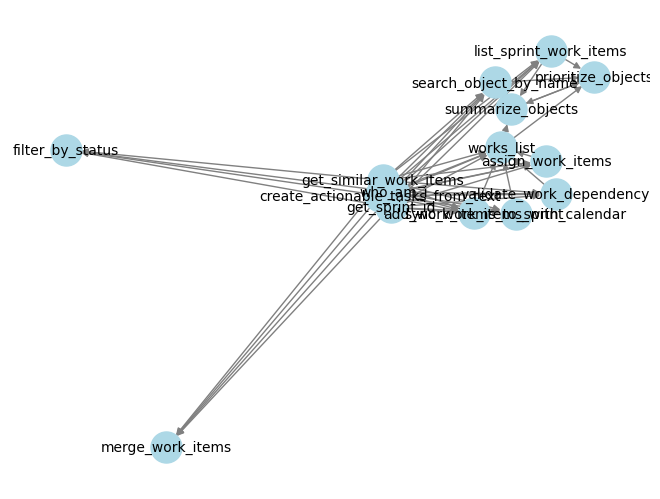

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', edge_color='gray')

# Show the graph
plt.show()


# reading sample text

In [9]:
with open('sample_examples.txt', 'r') as file:
  queries=[]
  solutions=[]
  running_soln=""
  lines = file.readlines()
  for line in lines:
    line = line.strip()  # Remove leading/trailing whitespace
    if line.startswith("Query:"):
      query = line.replace("Query:", "").strip()  # Get query text
      queries.append(query)
    elif line.startswith("Solution:"):
      if len(queries)!=1:
        solutions.append(running_soln)
        running_soln=""
      solution = line.replace("Solution:", "").strip()
      running_soln=running_soln+solution
    else:
      running_soln=running_soln+line
  solutions.append(running_soln)

# Augmenting the tool description

In [10]:
api_key = "OLh5cL6Lkh1Y9tXWXBQiUX79EKfrZDOc"
model = "mistral-small-latest"

In [11]:
client = Mistral(api_key=api_key)

In [12]:
def augment_description(i):
    chat_response = client.chat.complete(
        model= model,
        messages = [
            {
                "role": "system",
                "content": "You are an AI assistant designed to understand and explain the functionality of API tools. Your task is to analyze the given tool, break down its arguments, and generate a clear, concise, and informative description."
            },
            {
                "role": "assistant",
                "content": "Your task is to provide a detailed description of the provided tool's functionality. Carefully explain each argument it accepts, how the tool works, and what kind of output it generates. Summarize its purpose in a way that highlights its use cases, keeping the explanation clear for developers. Output the description in two sentences."
            },
            {
                "role": "user",
                "content": f"You are provided with the following tool, including its structure and arguments: {str(data[i])}."
            }
        ]
    )
    return chat_response.choices[0].message.content


In [13]:
descriptiond=[]
for i in range(len(data)):
  descriptiond.append(augment_description(i))
  time.sleep(5)

In [14]:
len(descriptiond)

15

In [15]:
new_descriptiond = []
for i in range(len(descriptiond)):
  new_description = str(data[i]['tool_name']) + ':' + str(descriptiond[i])
  new_descriptiond.append(new_description)
descriptions = new_descriptiond
new_descriptiond

["who_am_i:The tool 'who_am_i' is designed to return the ID of the current user. It does not accept any arguments and its output is a required string value. This tool is particularly useful for scenarios where you need to identify the current user's ID for authentication or personalization purposes in web applications.",
 "get_sprint_id:The tool 'get_sprint_id' is designed to retrieve the ID of the current sprint. It does not accept any arguments (`args: []`) and generates a single, required string output (`output: {'arg_type': 'str', 'is_array': False, 'is_required': True}`) containing the ID of the current sprint. This tool is useful for developers and project managers who need to programmatically access sprint information for tasks like automation, reporting, and integration with other tools.",
 "works_list:The 'works_list' tool is designed to return a list of work items that match specified criteria. It accepts a variety of filtering arguments such as 'applies_to_part' for work bel

In [16]:
len(descriptions)

15

In [17]:
for i in range(len(descriptions)):
    tool = descriptions[i].split(':')[0]
    data[i]['tool_description'] = descriptions[i].split(':')[1]

In [18]:
data[3]

{'tool_name': 'summarize_objects',
 'tool_description': "The tool named 'summarize_objects' takes a list of objects as input, regardless of their type, and generates a summary of these objects. The specific logic for summarizing different object types is handled internally by the tool. The output is a single, summarized result. This tool is useful for developers who need to condense or extract key information from a collection of varied data objects efficiently.",
 'args': [{'arg_name': 'objects',
   'arg_type': 'any',
   'is_array': True,
   'is_required': True,
   'arg_description': 'List of objects to summarize'}],
 'output': {'arg_type': 'any', 'is_array': False, 'is_required': True}}

# defining functions

## Retrieving tools based on L2 search

In [19]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

model1 = SentenceTransformer("ToolBench/ToolBench_IR_bert_based_uncased")

def generate_embeddings(descriptions, model1, t='cosine', add_tools=False, pre_index=None):
    sentences = descriptions
    embeddings = model1.encode(sentences)

    if (t == 'cosine'):
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) # Normalize the embeddings to use cosine similarity (L2 norm of 1)

    embedding_dimension = embeddings.shape[1]

    if(add_tools):
        index = pre_index
    else:
        if (t=='cosine'):
            index = faiss.IndexFlatIP(embedding_dimension)
        else:
            index = faiss.IndexFlatL2(embedding_dimension)

    index.add(embeddings)
    return index

index = generate_embeddings(descriptions, model1, t='cosine')
print('faiss index generated')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

faiss index generated


In [20]:
def return_retrieved_tools(query, model, index, k, t='cosine'):
    query_embedding = model.encode([query])
    relevance_dict={}

    if (t == 'cosine'):
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
    distances, indices = index.search(query_embedding, k)

    tools = []
    for i, idx in enumerate(indices[0]):
        tool_name = descriptions[idx].split(':')[0]
        matching_tools = [tool for tool in data if tool['tool_name'] == tool_name]
        relevance_dict[tool_name] = distances[0][i]
        tools.append(str(matching_tools[0]))



    return (distances, indices, tools, relevance_dict)

## Graph based augmentation

In [21]:
from collections import deque
import networkx as nx

def calculate_r_values(G, tools, relevance_dict, gamma):
    r_values = relevance_dict

    for tool in tools:
        queue = deque([(tool, 0, 0)])  # Track each tool with its level (depth)

        while queue:
            current_tool, level, cur_w = queue.popleft()


            for ancestor in G.predecessors(current_tool):
#                 print(ancestor)
                if ancestor not in r_values:
                    edge_data = G.get_edge_data(ancestor, current_tool)
                    weight = edge_data['weight']

                    t = level + 1  # Ancestor is one level higher than current tool

                    # Apply annealing factor gamma^t to the weight
                    annealed_weight = weight * (gamma ** t) + cur_w

                    if current_tool in relevance_dict:
                        r_value = relevance_dict[current_tool] * annealed_weight
                        r_values[ancestor] = r_value

                    # Add ancestor to the queue with incremented level
                    queue.append((ancestor, t, r_value))

    return r_values

## extracting thought and tools

In [22]:
import re

def extract_solution(text):
    # Use regex to find text between <Solution> and </Solution> tags
    match = re.search(r'<Solution>(.*?)</Solution>', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None

def extract_tools(thoughts):
    thoughts = json.loads(thoughts)
    tool_names = [item["tool_name"] for item in thoughts if "tool_name" in item]
    tools = []
    #print(tool_names)
#     print(tool_names)
    for tool in tool_names:
#         print(tool)
        matching_tools = [tool1 for tool1 in data if tool1['tool_name'] == tool]
        #print(matching_tools)
        if matching_tools:
          tools.append(matching_tools[0])
    return tools

## prompt templates

In [23]:
prompt = """
    "You are a helpful assistant. Your job is to decompose a user query into tasks that can be solved with one tool each.
    Tools should be taken from the given tool list only"
    "1. Analyse the list of tools and split the query into tasks. Solve the problem by thinking step by step. "
    "2. In each thought, think about what the next step should be in order to solve the problem, based on the available tools. "
    "Explain why the tool is required. "
    "3. Find the required tool that should be called (make sure it is related to the thought), and construct a task to be completed using it, based on the thought. "
    "If no tool is required, do not use any tool and return an empty list [] as the solution."
    "4. Ensure that each task contains the necessary information to call the tool associated with it. Do not create unnecessary steps if they haven't been mentioned in the query. "
    If the user request can’t be parsed, you need to reply empty JSON []. You should always respond in the following format:
<Solution><YOUR_SOLUTION></Solution>.
YOUR_SOLUTION> should be strict with JSON format described above.
Your knowledge base consists of tool descriptions and argument descriptions as explained below, if no tool given below satisfies, simply return an empty list:

"""

In [24]:
DECOMPOSITION_EXAMPLE="""Example:
        Query: Summarize high severity tickets from the customer (rev) UltimateCustomer and add them to the current sprint.
        Solution:<Solution>
        [
            {
                "thought": "First, we need to get the id of the customer UltimateCustomer",
                "tool_name": "search_object_by_name",
                "task": "Use the search_object_by_name tool with the argument 'query' = UltimateCustomer"
            },
            {
                "thought": "Next, we need to get the high severity tickets for the customer",
                "tool_name": "works_list",
                "task": "Use the works_list tool with the arguments: 'issue.rev_orgs' = "$$PREV[0]", 'ticket_severity' = 'high', and 'type' = 'ticket'."
            },
            {
                "thought": "Now, we need to summarize the high severity tickets obtained from the previous task",
                "tool_name": "summarize_objects",
                "task": "Use the summarize_objects tool with the output of the second task, argument 'objects' = "$$PREV[1]""
            },
            {
                "thought": "In order to add the tool to the current sprint, we need to get the current sprint ID",
                "tool_name": "get_sprint_id",
                "task": "Use the get_sprint_id tool to get the current sprint ID"
            },
            {
                "thought": "Finally, we need to add the work items obtained using works_list in the second task to the current sprint, whose ID was obtained in the previous task.",
                "tool_name": "add_work_items_to_sprint",
                "task": "Use the add_work_items_to_sprint tool with arguments 'work_ids'='$$PREV[1]' and 'sprint_id'='$$PREV[3]'
            }
        ]</Solution>
        """

In [25]:
DECOMPOSITION_EXAMPLE_3="""Example
Query : Obtain work items from the customer support channel, summarize the ones related to part 'FEAT-345' part and prioritize them.
Solution:<Solution>
[
    {
        "thought": "First, retrieve all work items from the customer support channel related to 'FEAT-345'.",
        "tool_name": "works_list",
        "task": "Use the 'works_list' tool with the arguments 'ticket.source_channel'= ['customer support'] and 'applies_to_part'= ["FEAT-345"]."
    },
    {
        "thought": "Next, summarize the work items related to 'FEAT-345' for clarity.",
        "tool_name": "summarize_objects",
        "task": "Use the 'summarize_objects' tool with the 'objects' argument being the output from the 'works_list' tool, 'objects'='$$PREV[0]'."
    },
    {
        "thought": "Finally, prioritize the issues from the customer support channel that are urgent.",
        "tool_name": "prioritize_objects",
        "task": "Use the 'prioritize_objects' tool with the 'objects' argument being the output from the 'works_list' tool, argument 'objects' = '$$PREV[0]'."
    }
]</Solution>
"""


In [26]:
JSON_formatting_prompt = """You are a helpful assistant. Your job is to output a json file which can be used to call the tool given
below, based on the task given to you.
You have implement the tools based on the `thoughts` given to you. Each thought corresponds to one tool.
The output of the ith task can be referenced using "$$PREV[i]" (starts from 0). This is important,
since many queries require a composition of tools.
You can't reference tools that haven't been called yet.
Tools must be explicitly called and cannot be called inside the arguments.

Output only the json format and nothing else
"""

In [30]:
TOOL_EXAMPLE="""Example:
        Query: Summarize high severity tickets from the customer UltimateCustomer.

        Completed Tasks and thought process:
        Task 0:
        Thought: First, we need to get the id of the customer UltimateCustomer
        Task: Use the search_object_by_name tool with the argument 'query' = UltimateCustomer
        Tool_name: search_object_by_name

        Your Task:
        Task 1:
        Thought: Next, we need to get the high severity tickets for the customer
        Task: Use the works_list tool with the arguments: 'issue.rev_orgs' = "$$PREV[0]", 'ticket_severity' = 'high', and 'type' = 'ticket'.
        Tool_name: works_list


        Answer:
        [{
            "tool_name": "works_list",
            "arguments": [
            {
                "argument_name": "ticket_rev_org",
                "argument_value":
                    '$$PREV[0]'

            },
            {
                "argument_name": "ticket_severity",
                "argument_value": [
                    'high'
                ]
            },
            {
                "argument_name": "type",
                "argument_value": [
                'ticket'
            ]
            }
        ]
        }]
        """

In [28]:
def preprocess(query,k):
  distances, indices, tools, relevance_dict = return_retrieved_tools(query, model1, index, k=12, t='cosine')
  retrieved_tools = [descriptions[i].split(':')[0] for i in indices[0]]
  r_values = calculate_r_values(G, retrieved_tools, relevance_dict, 0.9)
  r_values = dict(sorted(r_values.items(), key=lambda item: item[1], reverse=True))
  tools = [i for i in list(r_values.keys())[:k]]
  tools_comb = []
  for tool_name in tools:
      for tool in data:
          if (tool['tool_name'] == tool_name):
              tools_comb.append(str(tool))
  return tools_comb, r_values

In [29]:
a,b=preprocess(queries[5],12)
print(b)

{'summarize_objects': 0.4112026, 'get_sprint_id': 0.1719755, 'create_actionable_tasks_from_text': 0.15683486, 'who_am_i': 0.11246781, 'prioritize_objects': 0.09612114, 'search_object_by_name': 0.03700823485851288, 'assign_work_items': 0.008779706, 'add_work_items_to_sprint': 0.004390573, 'list_sprint_work_items': -0.0025383532, 'validate_work_dependency': -0.004900185652077198, 'merge_work_items': -0.010789604, 'works_list': -0.013611627, 'get_similar_work_items': -0.027102508, 'sync_work_items_with_calendar': -0.053191707}


In [31]:
def answer_query(query):
  tools_comb, r_values = preprocess(query,12)
  tools_str = " ".join(tools_comb)
  final_prompt = str(prompt) + tools_str + str(DECOMPOSITION_EXAMPLE)
  chat_response = client.chat.complete(
      model=model,
      messages=[
          {
              "role": "assistant",
              "content": str(final_prompt),
          },
          {
              "role": "user",
              "content": str(query),
          },

      ],
  )
  thoughts = extract_solution(chat_response.choices[0].message.content)
  tools = extract_tools(thoughts)
  user_prompt = f"""
  Query: {query}

  Thoughts = {thoughts}

  Tools = {tools}
  """
  #print(thoughts)
  fin_prompt=str(JSON_formatting_prompt)+str(TOOL_EXAMPLE)
  client2 = Mistral(api_key="OLh5cL6Lkh1Y9tXWXBQiUX79EKfrZDOc")
  chat_response2 = client2.chat.complete(
      model=model,
      messages=[
          {
              "role": "assistant",
              "content": fin_prompt,
          },
          {
              "role": "user",
              "content": user_prompt,
          },

      ],
  )
  response_content = chat_response2.choices[0].message.content
  response_content = response_content.strip('```')
  response_content = response_content.lstrip('json')
  return response_content

In [32]:
queries[0]

'List work items owned by ’DEVU-789’ needing response for organization ’REV-654’'

In [ ]:
query2="Jump from organization REV-654 from 8th floor"

In [33]:
json.loads(answer_query(queries[0]))

[{'tool_name': 'works_list',
  'arguments': [{'argument_name': 'owned_by', 'argument_value': ['DEVU-789']},
   {'argument_name': 'ticket_need_response', 'argument_value': True},
   {'argument_name': 'ticket_rev_org', 'argument_value': ['REV-654']}]}]

In [34]:
json.loads(solutions[0])

[{'tool_name': 'works_list',
  'arguments': [{'argument_name': 'owned_by', 'argument_value': ['DEVU-789']},
   {'argument_name': 'ticket_need_response', 'argument_value': True},
   {'argument_name': 'ticket_rev_org', 'argument_value': ['REV-654']}]}]

In [35]:
'''groundtruth=[]
predictedjson=[]
for i in range(len(solutions)):
  print(i)
  groundtruth.append(json.loads(solutions[i]))
  try:
    predictedjson.append(json.loads(answer_query(queries[i])))
  except:
    predictedjson.append(json.loads(answer_query(queries[i])))
  time.sleep(15)
'''

'groundtruth=[]\npredictedjson=[]\nfor i in range(len(solutions)):\n  print(i)\n  groundtruth.append(json.loads(solutions[i]))\n  try:\n    predictedjson.append(json.loads(answer_query(queries[i])))\n  except:\n    predictedjson.append(json.loads(answer_query(queries[i])))\n  time.sleep(15)\n'

In [36]:
groundtruth=[]
for i in range(len(solutions)):
  print(i)
  groundtruth.append(json.loads(solutions[i]))

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
#doing manually by changing i so that api rate not exceeded

In [37]:
predictedjson=[]

In [48]:
predictedjson.append(json.loads(answer_query(queries[10])))

# Evaluation Metrics-copy

## rouge

In [49]:
!pip install rouge_score -q

  Preparing metadata (setup.py) ... done


In [50]:
# rouge
from rouge_score import rouge_scorer

In [65]:
# The Rouge-l metric focuses on matching the longest common subsequence (LCS) between the reference (ground truth) and predicted text, and returning a relative score of similarity.

In [51]:
# Function to extract tools and their arguments from a JSON
def extract_tools_and_arguments(json_obj):
    tools = []
    for step in json_obj:
        tool_name = step.get("tool_name")
        arguments = step.get("arguments", [])
        if tool_name:
            # Flatten the arguments for comparison
            flat_arguments = {arg['argument_name']: arg['argument_value'] for arg in arguments}
            tools.append((tool_name, flat_arguments))
    return tools

# Function to convert tools and arguments into string format for ROUGE comparison
def tools_to_string(tools):
    result = []
    for tool_name, arguments in tools:
        # Convert each tool and its arguments to a formatted string
        argument_str = " ".join([f"{key}:{value}" for key, value in arguments.items()])
        result.append(f"tool_name:{tool_name} {argument_str}")
    return " ".join(result)

# Function to calculate ROUGE-L for JSON objects with multiple tool_names
def calculate_rouge_l_multiple_tools(ground_truth_jsons, predicted_jsons):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = []

    for ground_truth_json, predicted_json in zip(ground_truth_jsons, predicted_jsons):
        # Extract tools and arguments from both ground truth and predicted JSONs
        ground_truth_tools = extract_tools_and_arguments(ground_truth_json)
        predicted_tools = extract_tools_and_arguments(predicted_json)

        # Convert to text-like structure for ROUGE comparison
        gt_string = tools_to_string(ground_truth_tools)
        pred_string = tools_to_string(predicted_tools)

        # Calculate ROUGE-L score
        scores = scorer.score(gt_string, pred_string)
        rouge_l_scores.append(scores['rougeL'].fmeasure)  # We're interested in F-measure

    return rouge_l_scores



In [52]:
# Calculate ROUGE-L score for JSON-to-JSON comparison with multiple tools
rouge_l_scores = calculate_rouge_l_multiple_tools(groundtruth, predictedjson)

# Print the results
for i, rouge_l in enumerate(rouge_l_scores, start=1):
    print(f"Example {i}: ROUGE-L Score: {rouge_l:.4f}")

Example 1: ROUGE-L Score: 1.0000
Example 2: ROUGE-L Score: 1.0000
Example 3: ROUGE-L Score: 0.8696
Example 4: ROUGE-L Score: 1.0000
Example 5: ROUGE-L Score: 0.7692
Example 6: ROUGE-L Score: 0.9375
Example 7: ROUGE-L Score: 1.0000
Example 8: ROUGE-L Score: 0.7200
Example 9: ROUGE-L Score: 1.0000
Example 10: ROUGE-L Score: 1.0000
Example 11: ROUGE-L Score: 0.8627


In [53]:
avg_rouge=0
for i, rouge_l in enumerate(rouge_l_scores, start=1):
    print(f"Example {i}: ROUGE-L Score: {rouge_l:.4f}")
    avg_rouge+=rouge_l
print(f"Average ROUGE-L Score: {avg_rouge/len(rouge_l_scores):.4f}")

Example 1: ROUGE-L Score: 1.0000
Example 2: ROUGE-L Score: 1.0000
Example 3: ROUGE-L Score: 0.8696
Example 4: ROUGE-L Score: 1.0000
Example 5: ROUGE-L Score: 0.7692
Example 6: ROUGE-L Score: 0.9375
Example 7: ROUGE-L Score: 1.0000
Example 8: ROUGE-L Score: 0.7200
Example 9: ROUGE-L Score: 1.0000
Example 10: ROUGE-L Score: 1.0000
Example 11: ROUGE-L Score: 0.8627
Average ROUGE-L Score: 0.9235


In [ ]:
queries[4]

'list their high-severity tickets for ’Globex’ user'

In [ ]:
groundtruth[4]

[{'tool_name': 'search_object_by_name',
  'arguments': [{'argument_name': 'query', 'argument_value': 'Globex'}]},
 {'tool_name': 'works_list',
  'arguments': [{'argument_name': 'created_by', 'argument_value': '$$PREV[0]'},
   {'argument_name': 'ticket_severity', 'argument_value': ['high']},
   {'argument_name': 'type', 'argument_value': ['ticket']}]}]

In [55]:
predictedjson[4]

[{'tool_name': 'who_am_i', 'arguments': []},
 {'tool_name': 'works_list',
  'arguments': [{'argument_name': 'created_by', 'argument_value': '$$PREV[0]'},
   {'argument_name': 'ticket_severity', 'argument_value': 'high'},
   {'argument_name': 'type', 'argument_value': 'ticket'}]}]

## bleu

In [66]:
# Bleu score compares similarities between our groundtruth and predicted answer using n-gram sequence comparison and considers factors like repetition.
# This is more useful for longer sequences, so for our test case, we generally get lower scores as our sequence has short length.
#Because of this we simple put more importance to the first few tokens in comparison.

In [56]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to extract tools and their arguments from a JSON
def extract_tools_and_arguments(json_obj):
    tools = []
    for step in json_obj:
        tool_name = step.get("tool_name")
        arguments = step.get("arguments", [])
        if tool_name:
            # Flatten the arguments for comparison
            flat_arguments = {arg['argument_name']: arg['argument_value'] for arg in arguments}
            tools.append((tool_name, flat_arguments))
    return tools

# Convert tools and arguments into tokenized format for BLEU comparison
def tools_to_tokens(tools):
    tokens = []
    for tool_name, arguments in tools:
        tokens.append(f"tool_name:{tool_name}")
        for arg_name, arg_value in arguments.items():
            tokens.append(f"{arg_name}:{arg_value}")
    #print("Tokenized sequence:", tokens)  # Add print statement for debugging
    return tokens

# Function to calculate BLEU score for JSON objects with multiple tools
def calculate_bleu_multiple_tools(ground_truth_jsons, predicted_jsons):
    bleu_scores = []
    smooth_func = SmoothingFunction().method2  # Use smoothing for short sequences

    for ground_truth_json, predicted_json in zip(ground_truth_jsons, predicted_jsons):
        # Extract tools and arguments from both ground truth and predicted JSONs
        ground_truth_tools = extract_tools_and_arguments(ground_truth_json)
        predicted_tools = extract_tools_and_arguments(predicted_json)

        # Convert to tokenized format for BLEU comparison
        gt_tokens = tools_to_tokens(ground_truth_tools)
        pred_tokens = tools_to_tokens(predicted_tools)

        # Calculate BLEU score
        bleu = sentence_bleu([gt_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_func)
        bleu_scores.append(bleu)

    return bleu_scores

In [58]:
# Calculate BLEU score for JSON-to-JSON comparison with multiple tools
bleu_scores = calculate_bleu_multiple_tools(groundtruth, predictedjson)

# Print the results
for i, bleu in enumerate(bleu_scores, start=1):
    print(f"Example {i}: BLEU Score: {bleu:.4f}")

Example 1: BLEU Score: 1.0000
Example 2: BLEU Score: 1.0000
Example 3: BLEU Score: 0.6065
Example 4: BLEU Score: 0.6124
Example 5: BLEU Score: 0.3275
Example 6: BLEU Score: 0.4769
Example 7: BLEU Score: 1.0000
Example 8: BLEU Score: 0.0000
Example 9: BLEU Score: 1.0000
Example 10: BLEU Score: 1.0000
Example 11: BLEU Score: 0.5092


In [59]:
avg_bleu=0
for i, bleu in enumerate(bleu_scores, start=1):
  avg_bleu+=bleu
  print(f"Example {i}: BLEU Score: {bleu:.4f}")
print(f"Average BLEU Score: {avg_bleu/len(bleu_scores):.4f}")

Example 1: BLEU Score: 1.0000
Example 2: BLEU Score: 1.0000
Example 3: BLEU Score: 0.6065
Example 4: BLEU Score: 0.6124
Example 5: BLEU Score: 0.3275
Example 6: BLEU Score: 0.4769
Example 7: BLEU Score: 1.0000
Example 8: BLEU Score: 0.0000
Example 9: BLEU Score: 1.0000
Example 10: BLEU Score: 1.0000
Example 11: BLEU Score: 0.5092
Average BLEU Score: 0.6848


## ir,mr,nr,hr metrics

In [ ]:
#The IR

In [60]:
from collections import Counter

In [61]:
# 5.1 Tool Selection Metrics
def calculate_tool_selection_metrics(predicted, ground_truth):
    predicted_tools = [tool['tool_name'] for tool in predicted]
    ground_truth_tools = [tool['tool_name'] for tool in ground_truth]

    total_predicted = len(predicted_tools)
    total_ground_truth = len(ground_truth_tools)

    irrelevant_tools = set(predicted_tools) - set(ground_truth_tools)
    necessary_tools_in_prediction = set(predicted_tools) & set(ground_truth_tools)
    missing_tools = set(ground_truth_tools) - set(predicted_tools)

    # Irrelevant Tool Inclusion Rate (IR)
    ir = len(irrelevant_tools) / total_predicted if total_predicted > 0 else 0
    # Necessary Tool Inclusion Rate (NR)
    nr = len(necessary_tools_in_prediction) / total_predicted if total_predicted > 0 else 0
    # Missing Tool Rate (MR)
    mr = len(missing_tools) / total_ground_truth if total_ground_truth > 0 else 0

    return ir, nr, mr

# 5.2 Argument Assignment Metrics
def calculate_hallucination_rate(predicted, ground_truth):
    hallucinated = 0
    total_args = 0

    for pred_tool in predicted:
        for gt_tool in ground_truth:
            if pred_tool['tool_name'] == gt_tool['tool_name']:
                # Extract argument names
                pred_args = [arg['argument_name'] for arg in pred_tool['arguments']]
                gt_args = [arg['argument_name'] for arg in gt_tool['arguments']]

                # Hallucinated arguments: arguments in the prediction but not in the ground truth
                hallucinated += len(set(pred_args) - set(gt_args))
                total_args += len(pred_args)

    # Resource Hallucination Rate (HR)
    hr = hallucinated / total_args if total_args > 0 else 0
    return hr

In [68]:
def count_tools(json_obj):
    tool_count = 0

    for step in json_obj:
        if 'tool_name' in step:
            tool_count += 1

    return tool_count

In [ ]:
ir_value=mr_value=hr_value=nr_value=0
for i in range(len(solutions)):
  ir, nr, mr = calculate_tool_selection_metrics(predictedjson[i], groundtruth[i])
  ir_value+=ir/count_tools(predictedjson[i])
  nr_value+=nr/count_tools(predictedjson[i])
  mr_value+=mr/count_tools(predictedjson[i])
  hr=calculate_hallucination_rate(predictedjson[i], groundtruth[i])
  hr_value+=hr
ir_avg=ir_value/len(solutions)
nr_avg=nr_value/len(solutions)
mr_avg=mr_value/len(solutions)
hr_avg=hr_value/len(solutions)
print("IR: " + str(ir_avg))
print("NR: " + str(nr_avg))
print("MR: " + str(mr_avg))
print("HR: " + str(hr_avg))

IR: 0.2727272727272727
NR: 0.7272727272727273
MR: 0.446969696969697
HR: 0.09848484848484848
